In [2]:
using MAT
using Glob
using PyCall
using PyPlot
using Random
using Eirene
using StatsBase
using Statistics
using Distributions
using DelimitedFiles

In [3]:
function generate_complete_sorting(num_red, num_green, num_r_cluster, num_g_cluster, seed)
    
    Random.seed!(seed);
    
    # place 'red' labelled cells
    amountpercluster = [];
    cellsleft = num_red
    cluster_size_sigma = 0.5
    for j in 1:(num_r_cluster - 1)
        amounttaken = 0;
        if(cellsleft != 0)
            amounttaken = rand(1:cellsleft);
        end
        push!(amountpercluster,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountpercluster, cellsleft)
    redcellpos = Array{Float64}(undef, 0, 2);
    celltypes = ones(num_red,1);
    for i in 1:num_r_cluster
        clustercenter = rand(Uniform(-8,8), 1, 2);
        sigma = rand(Uniform(0.1, cluster_size_sigma), 1, 2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells = transpose(rand(distribution,amountpercluster[i]));
        redcellpos = vcat(redcellpos,clustercells);
    end
    
    # place 'green' labelled cells
    amountperclusterg = [];
    cellsleft = num_green
    for j in 1:(num_g_cluster - 1)
        amounttaken = 0;
        if(cellsleft != 0)
            amounttaken = rand(1:cellsleft);            
        end

        push!(amountperclusterg,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountperclusterg, cellsleft)
    greencellpos = Array{Float64}(undef, 0, 2)

    for i in 1:num_g_cluster
        clustercenter = rand(Uniform(-8,8), 1, 2);
        sigma = rand(Uniform(0.1, cluster_size_sigma), 1, 2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells = transpose(rand(distribution,amountperclusterg[i]));
        greencellpos = vcat(greencellpos,clustercells);
    end
    
    cellpos = vcat(redcellpos, greencellpos);
    celltypes = vcat(celltypes, (ones(num_green,1) + ones(num_green,1)));
    
    posfile = matopen("complete_sorting_pos.mat", "w");
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("complete_sorting_types.mat", "w");
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes);
    
end

function generate_engulfment(num_red, num_green, num_green_clusters, seed)
    
    # 'red' cells are engulfed by green cells
    Random.seed!(seed);
    
    amountpercluster = [];
    largeclustercenter = rand(Uniform(-5, 5), 1, 2);
    largeclustersigma = rand(Uniform(2, 3), 1, 2);
    
    cellsleft = num_green;
    for j in 1:(num_green_clusters - 1)
        amounttaken = 0;
        if(cellsleft != 0)
            amounttaken = rand(1:cellsleft);
        end
        push!(amountpercluster,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountpercluster, cellsleft)
    greencellpos = Array{Float64}(undef, 0, 2);
    celltypes = ones(num_green,1);
    for i in 1:num_green_clusters
        # restrict cluster center within larger 'green' cell cluster
        clustercenter = [rand(Uniform(largeclustercenter[1] - largeclustersigma[1], 
                    largeclustercenter[1] + largeclustersigma[1])), 
            rand(Uniform(largeclustercenter[2] - largeclustersigma[2],
                    largeclustercenter[2] + largeclustersigma[2]))];
        sigma = rand(Uniform(0.1, 0.5), 1, 2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells =rand(distribution,amountpercluster[i]);
        clustercells = transpose(clustercells);
        greencellpos = vcat(greencellpos,clustercells);
    end
    
    redcellpos = Array{Float64}(undef, 0, 2);
    maindistribution = MvNormal(vec(largeclustercenter),vec(largeclustersigma));
    k = 1;
    while (k <= num_red)
        redcell = transpose(rand(maindistribution,1));
        isincluster = false;
        for l in 1:num_green
            dist = ((redcell[1] - greencellpos[l,1])^2 + (redcell[2] - greencellpos[l,2])^2)^0.5;
            if(dist <= 0.001)
                isincluster = true;
            else
                isincluster = false;
            end
        end
        if (!isincluster)
            redcellpos = vcat(redcellpos,redcell);
            
        else
            k -= 1;
        end
        k += 1;
    end
    
    cellpos = vcat(redcellpos, greencellpos);
    celltypes = ones(num_red, 1);
    celltypes = vcat(celltypes, (ones(num_green,1) + ones(num_green,1)));
    
    posfile = matopen("engulfment_pos.mat", "w");
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("engulfment_types.mat", "w");
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes);
    
end

function generate_checkerboard(num_green, num_red, num_rows, num_cols, seed)
    
    Random.seed!(seed);
    
    num_cluster = (num_rows*num_cols)÷2;
    partitionsg = sample(1:num_green, num_cluster - 1, replace = false)
    partitionsg = sort(partitionsg)
    partitionsr = sample(1:num_red, num_cluster - 1, replace = false)
    partitionsr = sort(partitionsr)
    
    amountperclusterg = [];
    push!(amountperclusterg, partitionsg[1])
    for j in 2:(num_cluster - 1)
        push!(amountperclusterg,partitionsg[j] - partitionsg[j-1]);
    end
    push!(amountperclusterg, num_green - partitionsg[num_cluster-1])
    
    amountperclusterr = [];
    push!(amountperclusterr, partitionsr[1])
    for j in 2:(num_cluster - 1)
        push!(amountperclusterr,partitionsr[j] - partitionsr[j-1]);
    end
    push!(amountperclusterr, num_red - partitionsr[num_cluster-1])
    
    checkertopleft = rand(Uniform(-8, -4), 1, 2);
    checkerspacing = rand(Uniform(0.5, 1.0));
    
    # select cell type for top-left corner
    redvsgreen = rand((0,1));
    redcellpos = Array{Float64}(undef, 0, 2);
    greencellpos = Array{Float64}(undef, 0, 2);
    redcount = 1;
    greencount = 1;
    
    for i in 1:num_rows
        for j in 1:num_cols
            parity = iseven(i + j);
            minigausscenter = [checkertopleft[1] + i*checkerspacing,checkertopleft[2] + j*checkerspacing]
            sigma = rand(Uniform(0.05, 0.15), 1, 2);
            distribution = MvNormal(vec(minigausscenter),vec(sigma));
            if(redvsgreen == 1)
                if(parity)
                    clustercells =rand(distribution,amountperclusterg[greencount]);
                    clustercells = transpose(clustercells);
                    greencellpos = vcat(greencellpos,clustercells);
                    greencount +=1;
                else
                    clustercells =rand(distribution,amountperclusterr[redcount]);
                    clustercells = transpose(clustercells);
                    redcellpos = vcat(redcellpos,clustercells);
                    redcount +=1;
                end
            else
                if(parity)
                    clustercells =rand(distribution,amountperclusterr[redcount]);
                    clustercells = transpose(clustercells);
                    redcellpos = vcat(redcellpos,clustercells);                    
                    redcount +=1;
                else
                    clustercells =rand(distribution,amountperclusterg[greencount]);
                    clustercells = transpose(clustercells);
                    greencellpos = vcat(greencellpos,clustercells);
                    greencount +=1;
                end
            end
        end
    end
    
    cellpos = vcat(redcellpos, greencellpos);
    celltypes = ones(num_red, 1);
    celltypes = vcat(celltypes, (ones(num_green,1) + ones(num_green,1)));
    
    posfile = matopen("checkerboard_pos.mat", "w");
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("checkerboard_types.mat", "w");
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes);
    
end

function generate_isolated_cells(num_red, num_green, seed)
    
    Random.seed!(seed);
    
    redcellpos = Array{Float64}(undef, 0, 2);
    greencellpos = Array{Float64}(undef, 0, 2);
    
    i = 1;
    while (i <= num_red)
        resetred = false;
        redcell = rand(Uniform(-9.5, 9.5), 1, 2);
        for j in eachrow(redcellpos)
            dist = sqrt((j[1] - redcell[1])^2+(j[2] - redcell[2])^2);
            if(dist <=0.5)
               resetred = true;
            end
        end
        if (resetred)
            i -= 1;
        else
            redcellpos = vcat(redcellpos,redcell);
            i += 1;
        end
    end
    
    k = 1;
    while (k <= num_green)
        reset = false;
        greencell = rand(Uniform(-9.5, 9.5), 1, 2);
        for l in eachrow(redcellpos)
            dist = sqrt((l[1] - greencell[1])^2+(l[2] - greencell[2])^2);
            if(dist <=0.5)
               reset = true; 
            end
        end
        for m in eachrow(greencellpos)
            dist = sqrt((m[1] - greencell[1])^2+(m[2] - greencell[2])^2);
            if(dist <=0.5)
               reset = true; 
            end
        end
        if(reset)
           k -=1; 
        else
            greencellpos = vcat(greencellpos,greencell);
            k+=1;
        end
    end
    
    cellpos = vcat(redcellpos, greencellpos);
    celltypes = ones(num_red, 1);
    celltypes = vcat(celltypes, (ones(num_green,1) + ones(num_green,1)));
    
    posfile = matopen("isolated_cells_pos.mat", "w");
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("isolated_cells_types.mat", "w");
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos,celltypes);
    
end

function plot_syn_data(cell_pos, cell_type)
    
    figure(figsize=(5,5), dpi=200)
    num_cells = size(cell_type)[1]
    for cid in range(1, stop=num_cells)
        if cell_type[cid] == 1.0
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="red")
        elseif cell_type[cid] == 2
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="green")
        else
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="blue")
            write(stderr, "WARNING: More than 2 cell types")
        end                
    end
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
end;

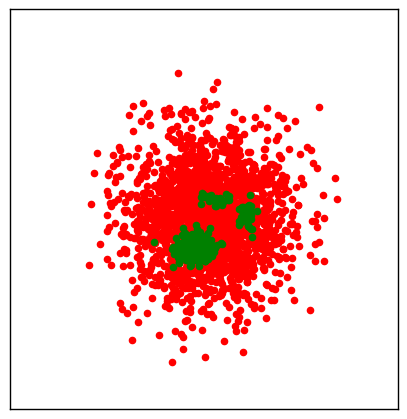

In [4]:
cellpos, celltypes = generate_engulfment(2000, 400, 3, 42)
plot_syn_data(cellpos, celltypes);

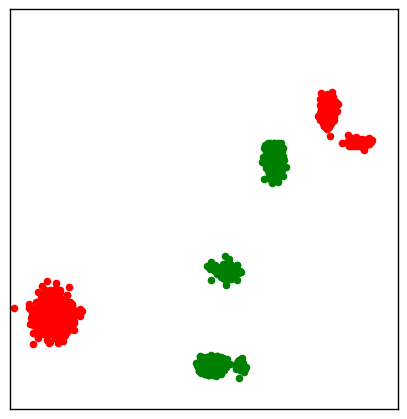

In [5]:
(cell_pos, cell_types) = generate_complete_sorting(1000, 2500, 3, 4, 42)
plot_syn_data(cell_pos, cell_types);

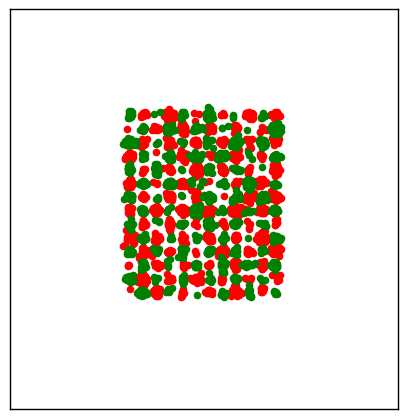

In [6]:
(cell_pos, cell_types) = generate_checkerboard(1500, 2000, 12, 14, 42)
plot_syn_data(cell_pos, cell_types);

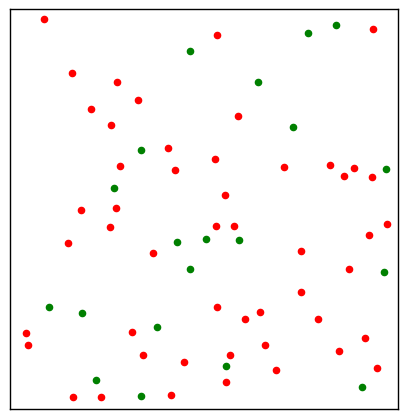

In [7]:
(cell_pos, cell_types) = generate_isolated_cells(50, 20, 42)
plot_syn_data(cell_pos, cell_types);